In [37]:
import os
import time
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point# views.py
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [38]:


url = "https://qlluxlhcvjnlicxzxwry.supabase.co/storage/v1/object/public/pdvs//filtered_data.csv"  
df = pd.read_csv(url)

df = df.rename(columns={"commune": "Commune",'latitude': 'Latitude', 'longitude': 'Longitude'})



# Load the GeoJSON file containing commune boundaries
communes = gpd.read_file(r"C:\Users\cash\Desktop\Mobilis\Model_Web\geoBoundaries-DZA-ADM3.geojson")

points_df =df
points_df["geometry"] = points_df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
points_gdf = gpd.GeoDataFrame(points_df, geometry="geometry", crs="EPSG:4326")

# Perform spatial join to find the corresponding commune for each point
df = gpd.sjoin(points_gdf, communes, how="left", predicate="within")

df['Commune']=df['shapeName']
df.dropna(inplace=True)

print(df)


               Nom du point de vente          Commune         Daira Wilaya  \
0    Point de Vente Alger-Centre 002  Central Algiers  Sidi M'Hamed  Alger   
1    Point de Vente Alger-Centre 003     Oued Koriche  Sidi M'Hamed  Alger   
2    Point de Vente Alger-Centre 005  Central Algiers  Sidi M'Hamed  Alger   
3    Point de Vente Alger-Centre 006  Central Algiers  Sidi M'Hamed  Alger   
4    Point de Vente Alger-Centre 008  Central Algiers  Sidi M'Hamed  Alger   
..                               ...              ...           ...    ...   
345     Point de Vente Bologhine 070         Bulughin   Bab El Oued  Alger   
346     Point de Vente Bologhine 076         Bulughin   Bab El Oued  Alger   
347     Point de Vente Bologhine 077        Bouzareah   Bab El Oued  Alger   
348     Point de Vente Bologhine 078         Bulughin   Bab El Oued  Alger   
349     Point de Vente Bologhine 079         Bulughin   Bab El Oued  Alger   

      Latitude  Longitude  Cluster                  geometry  i

In [39]:
# def find_best_k(df, initial_k=15):
#     """
#     Finds the best k for K-Means clustering based on silhouette score and inertia.

#     Parameters:
#     df (pd.DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns.
#     initial_k (int): Starting value for k. The function tests k in range [initial_k, 2*initial_k].

#     Returns:
#     int: Best k value based on silhouette score.
#     """
#     from sklearn.cluster import KMeans
#     from sklearn.metrics import silhouette_score
#     from sklearn.preprocessing import StandardScaler
#     import matplotlib.pyplot as plt

#     # Extract coordinates
#     X = df[["Latitude", "Longitude"]].values

#     # Standardize data
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Define k range
#     k_range = range(initial_k, 2 * initial_k + 1)

#     # Store metrics
#     inertia_values = []
#     silhouette_scores = []

#     # Run K-Means for each k
#     for k in k_range:
#         kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#         labels = kmeans.fit_predict(X_scaled)

#         inertia_values.append(kmeans.inertia_)
#         silhouette_scores.append(silhouette_score(X_scaled, labels))

#     # Determine the best k based on the highest silhouette score
#     best_k = k_range[np.argmax(silhouette_scores)]

#     # Plot results
#     fig, ax1 = plt.subplots()

#     ax1.set_xlabel("Number of Clusters (k)")
#     ax1.set_ylabel("Inertia", color="tab:blue")
#     ax1.plot(k_range, inertia_values, "o-", color="tab:blue", label="Inertia")
#     ax1.tick_params(axis="y", labelcolor="tab:blue")

#     ax2 = ax1.twinx()
#     ax2.set_ylabel("Silhouette Score", color="tab:red")
#     ax2.plot(k_range, silhouette_scores, "s-", color="tab:red", label="Silhouette Score")
#     ax2.tick_params(axis="y", labelcolor="tab:red")

#     plt.title("Choosing the Best k for K-Means")
#     plt.show()

#     return best_k,max(silhouette_scores)

# # Test the function with initial_k = 15
# best_k,sil = find_best_k(df, initial_k=20)
# print(best_k)
# print(sil)


In [40]:
def cluster_points(df, initial_k=20):
    """
    This function clusters points based on Latitude and Longitude
    by determining the best k using cohesion (inertia) and separation (silhouette score).

    Parameters:
    - df: DataFrame containing the Latitude and Longitude columns
    - initial_k: initial value of k to start the clustering

    Returns:
    - Best k value
    - DataFrame with the assigned clusters
    """
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    # Extract coordinates
    X = df[["Latitude", "Longitude"]].values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define the range of k values
    k_range = range(initial_k, 2 * initial_k + 1)

    # Initialize lists to store inertia and silhouette scores
    inertia_values = []
    silhouette_scores = []

    # Run K-Means for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=300)
        labels = kmeans.fit_predict(X_scaled)

        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Determine the best k based on the highest silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]

    # Final clustering with the best k
    final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
    df["Cluster"] = final_kmeans.fit_predict(X_scaled)

    return best_k, df

# Call the function
best_k, clustered_df = cluster_points(df, initial_k=20)
best_k, clustered_df.head()


(38,
              Nom du point de vente          Commune         Daira Wilaya  \
 0  Point de Vente Alger-Centre 002  Central Algiers  Sidi M'Hamed  Alger   
 1  Point de Vente Alger-Centre 003     Oued Koriche  Sidi M'Hamed  Alger   
 2  Point de Vente Alger-Centre 005  Central Algiers  Sidi M'Hamed  Alger   
 3  Point de Vente Alger-Centre 006  Central Algiers  Sidi M'Hamed  Alger   
 4  Point de Vente Alger-Centre 008  Central Algiers  Sidi M'Hamed  Alger   
 
     Latitude  Longitude  Cluster                  geometry  index_right  \
 0  36.776655   3.059659        5  POINT (3.05966 36.77665)       1536.0   
 1  36.778563   3.048757        4  POINT (3.04876 36.77856)       1533.0   
 2  36.769009   3.062960       25  POINT (3.06296 36.76901)       1536.0   
 3  36.780301   3.065276       22   POINT (3.06528 36.7803)       1536.0   
 4  36.775311   3.061397        5   POINT (3.0614 36.77531)       1536.0   
 
          shapeName shapeISO                  shapeID shapeGroup shapeTyp

In [41]:
import folium
from folium.plugins import MarkerCluster

def plot_clusters_on_map(df, map_center=(36.75, 3.05), zoom_start=12):
    """
    This function plots the points with clusters on a map using Folium.

    Parameters:
    - df: DataFrame containing Latitude, Longitude, and Cluster columns
    - map_center: Tuple representing the center of the map (default is near Algiers)
    - zoom_start: Initial zoom level for the map (default is 12)

    Returns:
    - folium Map object
    """
    # Create a map centered around the given coordinates
    folium_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Initialize a marker cluster
    marker_cluster = MarkerCluster().add_to(folium_map)

    # Plot the points
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=(row["Latitude"], row["Longitude"]),
            radius=5,
            color=f'#{hex(row["Cluster"]*1000)[2:]}',  # Assign color based on cluster number
            fill=True,
            fill_color=f'#{hex(row["Cluster"]*1000)[2:]}',
            fill_opacity=0.6,
            popup=row["Nom du point de vente"]  # Add the name of the point of sale as popup
        ).add_to(marker_cluster)

    return folium_map

# Example usage (you would run this after clustering and having a `clustered_df`):
folium_map = plot_clusters_on_map(clustered_df)
folium_map.save('clustered1_map.html')  # Save the map to an HTML file to view it


In [42]:
def cluster_sizes(df):
    """
    This function calculates the size of each cluster.

    Parameters:
    - df: DataFrame containing the Cluster column.

    Returns:
    - A DataFrame with the cluster number and the size of each cluster.
    """
    cluster_size = df.groupby('Cluster').size().reset_index(name='Cluster Size')
    return cluster_size

# Example usage (after clustering):
cluster_sizes(clustered_df)


,Cluster,Cluster Size
0,0,9
1,1,7
2,2,7
3,3,7
4,4,11
5,5,9
6,6,12
7,7,11
8,8,17
9,9,9


In [43]:
def clusters_with_multiple_communes(df):
    """
    This function retrieves clusters where the points are not all in the same commune.

    Parameters:
    - df: DataFrame containing the 'Cluster' and 'Commune' columns.

    Returns:
    - A DataFrame with clusters that contain points from multiple communes.
    """
    # Group by cluster and commune, then count the unique communes per cluster
    cluster_commune_count = df.groupby('Cluster')['Commune'].nunique()

    # Filter clusters where the count of unique communes is greater than 1
    multi_commune_clusters = cluster_commune_count[cluster_commune_count > 1]

    # Return the clusters that have points in multiple communes
    return multi_commune_clusters

# Example usage (after clustering):
multi_commune_clusters = clusters_with_multiple_communes(clustered_df)
print(len(multi_commune_clusters))
len(df['Cluster'].unique())


21


38

In [44]:
def split_clusters_by_commune(df):
    """
    This function splits clusters that have points from multiple communes
    into smaller clusters where each cluster has only one unique commune.

    Parameters:
    - df: DataFrame containing 'Cluster' and 'Commune' columns.

    Returns:
    - DataFrame with the updated 'Cluster' column.
    """
    # Identify clusters with points from multiple communes
    multi_commune_clusters = clusters_with_multiple_communes(df)

    # Create a new cluster assignment column
    new_cluster_label = df['Cluster'].copy()

    # Loop through each multi-commune cluster
    for cluster in multi_commune_clusters.index:
        # Extract the points in this cluster
        points_in_cluster = df[df['Cluster'] == cluster]

        # Get the unique communes in this cluster
        unique_communes = points_in_cluster['Commune'].unique()

        # Assign a new cluster for each commune in this cluster
        new_cluster_num = 0
        for commune in unique_communes:
            # Find points that belong to the current commune
            points_in_commune = points_in_cluster[points_in_cluster['Commune'] == commune]
            
            # Assign a new cluster number
            new_cluster_label[points_in_commune.index] = cluster * 1000 + new_cluster_num  # New unique label
            new_cluster_num += 1

    # Update the DataFrame with the new clusters
    df['Cluster'] = new_cluster_label

    return df

# Example usage (after clustering):
updated_clustered_df = split_clusters_by_commune(clustered_df)
updated_clustered_df.head()


,Nom du point de vente,Commune,Daira,Wilaya,Latitude,Longitude,Cluster,geometry,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType
0,Point de Vente Alger-Centre 002,Central Algiers,Sidi M'Hamed,Alger,36.776655,3.059659,5,POINT (3.05966 36.77665),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
1,Point de Vente Alger-Centre 003,Oued Koriche,Sidi M'Hamed,Alger,36.778563,3.048757,4000,POINT (3.04876 36.77856),1533.0,Oued Koriche,,69997007B48222429430755,DZA,ADM3
2,Point de Vente Alger-Centre 005,Central Algiers,Sidi M'Hamed,Alger,36.769009,3.062960,25,POINT (3.06296 36.76901),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
3,Point de Vente Alger-Centre 006,Central Algiers,Sidi M'Hamed,Alger,36.780301,3.065276,22000,POINT (3.06528 36.7803),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
4,Point de Vente Alger-Centre 008,Central Algiers,Sidi M'Hamed,Alger,36.775311,3.061397,5,POINT (3.0614 36.77531),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3


In [45]:
print(len(df['Cluster'].unique()))

63


In [46]:
from sklearn.neighbors import NearestNeighbors

def assign_single_point_clusters(df):
    """
    This function assigns clusters of size 1 to the closest cluster of the same commune.

    Parameters:
    - df: DataFrame containing 'Cluster', 'Latitude', 'Longitude', and 'Commune' columns.

    Returns:
    - DataFrame with the updated 'Cluster' column.
    """
    # Step 1: Identify clusters of size 1
    cluster_sizes = df['Cluster'].value_counts()
    single_point_clusters = cluster_sizes[cluster_sizes == 1].index

    # Step 2: For each single point cluster, find the closest cluster in the same commune
    for cluster in single_point_clusters:
        # Get the point in the current single-point cluster
        point = df[df['Cluster'] == cluster].iloc[0]
        commune = point['Commune']
        point_coords = np.array([[point['Latitude'], point['Longitude']]])

        # Step 3: Find all clusters in the same commune
        same_commune_points = df[df['Commune'] == commune]
        
        # Remove the current single point cluster from the same commune points
        same_commune_points = same_commune_points[same_commune_points['Cluster'] != cluster]

        # Step 4: If there are other clusters in the same commune, find the closest one
        if len(same_commune_points) > 0:
            # Use NearestNeighbors to find the closest cluster
            coords = same_commune_points[['Latitude', 'Longitude']].values
            nbrs = NearestNeighbors(n_neighbors=1).fit(coords)
            _, indices = nbrs.kneighbors(point_coords)
            
            # Get the closest point's cluster
            closest_cluster = same_commune_points.iloc[indices[0][0]]['Cluster']
            
            # Assign the current point to the closest cluster
            df.loc[df['Cluster'] == cluster, 'Cluster'] = closest_cluster

    return df

# Example usage (after clustering and assigning communes):
updated_clustered_df = assign_single_point_clusters(updated_clustered_df)
updated_clustered_df.head()


,Nom du point de vente,Commune,Daira,Wilaya,Latitude,Longitude,Cluster,geometry,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType
0,Point de Vente Alger-Centre 002,Central Algiers,Sidi M'Hamed,Alger,36.776655,3.059659,5,POINT (3.05966 36.77665),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
1,Point de Vente Alger-Centre 003,Oued Koriche,Sidi M'Hamed,Alger,36.778563,3.048757,4000,POINT (3.04876 36.77856),1533.0,Oued Koriche,,69997007B48222429430755,DZA,ADM3
2,Point de Vente Alger-Centre 005,Central Algiers,Sidi M'Hamed,Alger,36.769009,3.062960,25,POINT (3.06296 36.76901),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
3,Point de Vente Alger-Centre 006,Central Algiers,Sidi M'Hamed,Alger,36.780301,3.065276,22000,POINT (3.06528 36.7803),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3
4,Point de Vente Alger-Centre 008,Central Algiers,Sidi M'Hamed,Alger,36.775311,3.061397,5,POINT (3.0614 36.77531),1536.0,Central Algiers,,69997007B96766570187701,DZA,ADM3


In [47]:
cluster_sizes(updated_clustered_df)

,Cluster,Cluster Size
0,0,8
1,1,8
2,2,8
3,3,7
4,5,9
5,6,13
6,15,4
7,16,10
8,17,7
9,18,4


In [48]:
import geojson
import pandas as pd
from shapely.geometry import MultiPoint, Point, Polygon

def create_geojson(df):
    """
    This function creates a GeoJSON for the clusters, where:
    - Clusters with only one point are represented as Points.
    - Clusters with two points are represented as Circles (approximated as squares).
    - Clusters with more than two points are represented as Polygons (using convex hull).
    
    Parameters:
    - df: DataFrame containing the 'Cluster', 'Latitude', 'Longitude', and 'Commune' columns.
    
    Returns:
    - GeoJSON object.
    """
    # Ensure the DataFrame is using native Python data types
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)
    df['Cluster'] = df['Cluster'].astype(str)
    
    features = []
    
    # Iterate over each cluster
    for cluster in df['Cluster'].unique():
        cluster_points = df[df['Cluster'] == cluster]
        
        # If the cluster has only one point, represent it as a Point
        if len(cluster_points) == 1:
            point = cluster_points.iloc[0]
            point_feature = geojson.Feature(
                geometry=geojson.Point((point['Longitude'], point['Latitude'])),
                properties={"Cluster": cluster, "Commune": point['Commune']}
            )
            features.append(point_feature)
        
        # If the cluster has exactly two points, represent it as a Circle (approximate)
        elif len(cluster_points) == 2:
            point1 = cluster_points.iloc[0]
            point2 = cluster_points.iloc[1]
            # Calculate the center of the circle (midpoint of the two points)
            center_lat = (point1['Latitude'] + point2['Latitude']) / 2
            center_lon = (point1['Longitude'] + point2['Longitude']) / 2
            # Approximate radius in degrees (around 0.001 degrees per 100 meters)
            radius = 0.002  # Adjust this based on your data's scale

            circle_feature = geojson.Feature(
                geometry=geojson.GeometryCollection([ 
                    geojson.Point((center_lon, center_lat)),
                    geojson.Polygon([[ 
                        (center_lon + radius, center_lat),
                        (center_lon - radius, center_lat),
                        (center_lon, center_lat + radius),
                        (center_lon, center_lat - radius)
                    ]])]),  # Simple square for circle approximation
                properties={"Cluster": cluster, "Commune": point1['Commune']}
            )
            features.append(circle_feature)
        
        # If the cluster has more than two points, represent it as a Polygon (Convex Hull)
        else:
            points = [Point(row['Longitude'], row['Latitude']) for idx, row in cluster_points.iterrows()]
            multipoint = MultiPoint(points)
            convex_hull = multipoint.convex_hull  # Calculate the convex hull to form a polygon
            
            # Convert the convex hull to GeoJSON format
            polygon_coords = [(x[0], x[1]) for x in convex_hull.exterior.coords]
            polygon_feature = geojson.Feature(
                geometry=geojson.Polygon([polygon_coords]),
                properties={"Cluster": cluster, "Commune": cluster_points['Commune'].iloc[0]}
            )
            features.append(polygon_feature)

    # Create the GeoJSON object
    geojson_data = geojson.FeatureCollection(features)
    
    return geojson_data

# Example usage (assuming df is your DataFrame with the necessary columns)
# df = your_dataframe

# Generate the GeoJSON data
geojson_result = create_geojson(df)

# Save the GeoJSON to a file
with open("clusters.geojson", "w") as f:
    geojson.dump(geojson_result, f)

# Return the GeoJSON data for further processing
geojson_result


{"features": [{"geometry": {"coordinates": [[[3.059473, 36.774159], [3.059028, 36.77679], [3.061162, 36.778764], [3.06243, 36.776528], [3.062167, 36.776022], [3.061397, 36.775311], [3.059473, 36.774159]]], "type": "Polygon"}, "properties": {"Cluster": "5", "Commune": "Central Algiers"}, "type": "Feature"}, {"geometry": {"coordinates": [[[3.049406, 36.778017], [3.048757, 36.778563], [3.046354, 36.78101], [3.049406, 36.778017]]], "type": "Polygon"}, "properties": {"Cluster": "4000", "Commune": "Oued Koriche"}, "type": "Feature"}, {"geometry": {"coordinates": [[[3.06296, 36.769009], [3.060595, 36.770466], [3.060534, 36.771933], [3.063071, 36.771995], [3.06296, 36.769009]]], "type": "Polygon"}, "properties": {"Cluster": "25", "Commune": "Central Algiers"}, "type": "Feature"}, {"geometry": {"geometries": [{"coordinates": [3.064343, 36.780608], "type": "Point"}, {"coordinates": [[[3.066343, 36.780608], [3.062343, 36.780608], [3.064343, 36.782608], [3.064343, 36.778608]]], "type": "Polygon"}]

In [49]:
import folium
import random

def display_clusters_on_map(geojson_data):
    """
    This function creates a folium map and displays clusters from the given GeoJSON data, 
    where each cluster is styled with a unique color and displays the cluster number on click.

    Parameters:
    - geojson_data: The GeoJSON data representing the clusters.

    Returns:
    - folium map object.
    """
    # Create a map centered at an approximate location (the centroid of the first point or a central location)
    map_center = [36.75, 3.06]  # Example: Centered on Algiers (adjust if needed)
    m = folium.Map(location=map_center, zoom_start=12)

    # Define a function to generate random colors for each cluster
    def random_color():
        return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # Define a function to style the clusters based on their cluster number
    def style_function(feature):
        # Get the cluster number (which is stored in the properties of each GeoJSON feature)
        cluster_id = feature['properties']['Cluster']
        
        # Assign a random color for each cluster
        return {
            'fillColor': random_color(),
            'color': 'black',  # Border color
            'weight': 2,       # Border weight
            'fillOpacity': 0.6 # Fill opacity
        }

    # Add the GeoJSON data to the map with custom styling and popups on click
    folium.GeoJson(
        geojson_data,
        style_function=style_function,
        popup=folium.GeoJsonPopup(fields=['Cluster'], localize=True)  # Corrected to avoid labels parameter
    ).add_to(m)

    return m

# Example usage:
# After creating the GeoJSON from the clusters:
geojson_result = create_geojson(updated_clustered_df)

# Display the clusters on a map
map_object = display_clusters_on_map(geojson_result)

# Save the map as an HTML file to open in a browser
map_object.save("clusters_map_with_popup.html")

# Optionally, display the map inline if you're using a Jupyter Notebook
map_object


In [50]:
(df[df['Cluster']=='1'])

,Nom du point de vente,Commune,Daira,Wilaya,Latitude,Longitude,Cluster,geometry,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType
40,Point de Vente Alger-Centre 112,Sidi M'Hamed,Sidi M'Hamed,Alger,36.766291,3.054501,1,POINT (3.0545 36.76629),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
67,Point de Vente Sidi M'Hamed 018,Sidi M'Hamed,Sidi M'Hamed,Alger,36.764365,3.053635,1,POINT (3.05363 36.76437),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
80,Point de Vente Sidi M'Hamed 036,Sidi M'Hamed,Sidi M'Hamed,Alger,36.764201,3.057166,1,POINT (3.05717 36.7642),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
128,Point de Vente Sidi M'Hamed 114,Sidi M'Hamed,Sidi M'Hamed,Alger,36.765890,3.056561,1,POINT (3.05656 36.76589),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
134,Point de Vente Sidi M'Hamed 123,Sidi M'Hamed,Sidi M'Hamed,Alger,36.763138,3.053895,1,POINT (3.05389 36.76314),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
238,Point de Vente Belouizdad 083,Sidi M'Hamed,Hussein Dey,Alger,36.762973,3.055773,1,POINT (3.05577 36.76297),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
250,Point de Vente Belouizdad 098,Sidi M'Hamed,Hussein Dey,Alger,36.762900,3.055016,1,POINT (3.05502 36.7629),1537.0,Sidi M'Hamed,,69997007B30861673379456,DZA,ADM3
298,Point de Vente Bab El Oued 130,Bulughin,Bab El Oued,Alger,36.800421,3.049060,1,POINT (3.04906 36.80042),1484.0,Bulughin,,69997007B94453714677914,DZA,ADM3


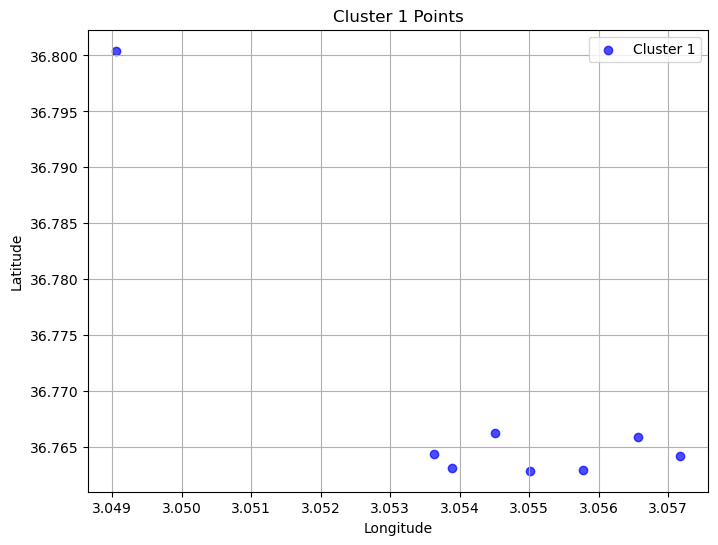

In [51]:
import matplotlib.pyplot as plt

def plot_single_cluster(df, cluster_id):
    """
    This function plots the points of a specific cluster.
    
    Parameters:
    - df: DataFrame containing 'Cluster', 'Latitude', and 'Longitude' columns.
    - cluster_id: The ID of the cluster to plot.
    """
    # Filter the DataFrame to get points for the specified cluster
    cluster_points = df[df['Cluster'] == cluster_id]
    
    # Extract latitude and longitude
    latitudes = cluster_points['Latitude']
    longitudes = cluster_points['Longitude']
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(longitudes, latitudes, c='blue', label=f'Cluster {cluster_id}', alpha=0.7)
    plt.title(f'Cluster {cluster_id} Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming your DataFrame is `df` and you want to plot the points of cluster 1
plot_single_cluster(df, cluster_id='1'
                    )
